<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY" data-toc-modified-id="IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY</a></span><ul class="toc-item"><li><span><a href="#Air-quality-Data-Exploration-and-Cleanup" data-toc-modified-id="Air-quality-Data-Exploration-and-Cleanup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Air quality Data Exploration and Cleanup</a></span><ul class="toc-item"><li><span><a href="#Import-datasets-and-overview-of-the-air-quality-data" data-toc-modified-id="Import-datasets-and-overview-of-the-air-quality-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Import datasets and overview of the air quality data</a></span></li><li><span><a href="#Slice-and-dice-the-data" data-toc-modified-id="Slice-and-dice-the-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Slice and dice the data</a></span></li><li><span><a href="#Overview-of-the-median-value-distribution-of-the-major-air-pollutants" data-toc-modified-id="Overview-of-the-median-value-distribution-of-the-major-air-pollutants-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Overview of the median value distribution of the major air pollutants</a></span></li><li><span><a href="#Visualise-air-quality-change-in-Australia-(Melbourne,-Sydney-and-Perth)-in-2019-2020H1" data-toc-modified-id="Visualise-air-quality-change-in-Australia-(Melbourne,-Sydney-and-Perth)-in-2019-2020H1-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Visualise air quality change in Australia (Melbourne, Sydney and Perth) in 2019-2020H1</a></span></li><li><span><a href="#Visualise-air-quality-change-in-India-(Mumbai,-Delhi,-Hyderabad)-in-2019-2020H1" data-toc-modified-id="Visualise-air-quality-change-in-India-(Mumbai,-Delhi,-Hyderabad)-in-2019-2020H1-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Visualise air quality change in India (Mumbai, Delhi, Hyderabad) in 2019-2020H1</a></span></li></ul></li><li><span><a href="#COVID-19-World-Data-Exploration-and-Clean-Up" data-toc-modified-id="COVID-19-World-Data-Exploration-and-Clean-Up-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>COVID-19 World Data Exploration and Clean Up</a></span></li></ul></li></ul></div>

# IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY

## Air quality Data Exploration and Cleanup

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import datetime
from pprint import pprint
from scipy.stats import linregress

"https://aqicn.org/data-platform/covid19/
With the COVID-19 spreading out all over the world, the World Air Quality Index project team saw a surge in requests for global data covering the whole world map. As a result, the WAQI project is now providing a new dedicated data-set, updated 3 times a day, and covering about 380 major cities in the world, from January 2020 until now.

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation."

### Import datasets and overview of the air quality data

In [2]:
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

In [3]:
airdf_2019_2020 = pd.concat(df_list, ignore_index=True)

In [4]:
airdf_2019_2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,31/05/2020,IR,Isfahan,temperature,120,17.5,35.0,27.5,331.51
1,13/06/2020,IR,Isfahan,temperature,144,16.0,36.5,27.5,488.74
2,3/07/2020,IR,Isfahan,temperature,67,19.0,33.0,24.0,128.08
3,28/03/2020,IR,Isfahan,temperature,240,3.0,14.0,9.5,136.68
4,23/04/2020,IR,Isfahan,temperature,168,6.0,25.5,16.0,400.79


### Slice and dice the data

In [5]:
# Display an overview of the Specie column
airdf_2019_2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1'], dtype=object)

In [6]:
airdf_2019_2020["Specie"].value_counts()

temperature      310236
humidity         310145
pressure         308517
pm25             270688
no2              266793
pm10             264859
wind-speed       263292
o3               250438
so2              226576
dew              226147
co               203776
wind-gust        172805
wind speed        47002
wind gust         29576
precipitation     26825
wd                25720
aqi                8267
uvi                5632
pol                3790
pm1                1380
mepaqi              564
neph                440
Name: Specie, dtype: int64

> We understand that "Air movements influence the fate of air pollutants. So any study of air pollution should include a study of the local weather patterns (meteorology). If the air is calm and pollutants cannot disperse, then the concentration of these pollutants will build up. On the other hand, when strong, turbulent winds blow, pollutants disperse quickly, resulting in lower pollutant concentrations." https://www.qld.gov.au/environment/pollution/monitoring/air/air-monitoring/meteorology-influence/meteorology-factors#:~:text=Meteorological%20factors-,Meteorological%20factors,these%20pollutants%20will%20build%20up.
Hence the Meteorology parameters like temperature, humidity, pressure, wind speed, to name a few, should have some sorts of correlations with the air quality.
(http://www.bom.gov.au/vic/observations/melbourne.shtml)

> However, due to the scope of our project, we'll only focus on air pollutant parameters to assess their changes before COVID-19 and 6 months into the pandemic. We're not trying to explain the causes of air quality change. Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**.
https://aqicn.org/publishingdata/

> We'll also remove species with the least number of available data points  including **aqi, pol, pm1, mepaqi, neph**.

In [7]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "aqi", "uvi", "pol", "pm1", "mepaqi", "neph"]

short_airdf = airdf_2019_2020[~airdf_2019_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [8]:
short_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,24/02/2020,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,7/05/2020,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,28/05/2020,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,20/02/2020,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,23/02/2020,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [9]:
short_airdf["Specie"].value_counts()

pm25    270688
no2     266793
pm10    264859
o3      250438
so2     226576
co      203776
Name: Specie, dtype: int64

More about AQI:
https://www.airnow.gov/aqi/aqi-basics/
https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
"Five major pollutants:
EPA establishes an AQI for five major air pollutants regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:

* Ground-level ozone **o3** (ppm - parts per million)
* Particulate Matter - including PM2.5 **pm25** and PM10 **pm10** (μg/m3)
* Carbon Monoxide **co** (ppm)
* Sulfur Dioxide **so2** (ppb - parts per billion)
* Nitrogen Dioxide **no2** (ppb)

More details about the 5 major outdoor air pollutants could be referred to https://learn.kaiterra.com/en/air-academy/5-major-outdoor-air-pollutants

"https://waqi.info/
The Air Quality Index is based on measurement of particulate matter (PM2.5 and PM10), Ozone (O3), Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2) and Carbon Monoxide (CO) emissions. Most of the stations on the map are monitoring both PM2.5 and PM10 data, but there are few exceptions where only PM10 is available.

All measurements are based on hourly readings: For instance, an AQI reported at 8AM means that the measurement was done from 7AM to 8AM.
More details https://aqicn.org/faq/


https://www.weatherbit.io/api/airquality-history#:~:text=Air%20Quality%20API%20(Historical),an%20air%20quality%20index%20score.

aqi: Air Quality Index [US - EPA standard 0 - +500]
o3: Concentration of surface O3 (µg/m³)
so2: Concentration of surface SO2 (µg/m³)
no2: Concentration of surface NO2 (µg/m³)
co: Concentration of carbon monoxide (µg/m³)
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)
pm10: Concentration of particulate matter < 10 microns (µg/m³)

Some good info on air pollution impacts https://ourworldindata.org/air-pollution
https://www.who.int/health-topics/air-pollution#tab=tab_1
https://www.epa.vic.gov.au/for-community/airwatch
https://www.kaggle.com/frtgnn/clean-air-india-s-air-quality/data

In [10]:
short_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483130 entries, 0 to 1483129
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Date      1483130 non-null  object 
 1   Country   1483130 non-null  object 
 2   City      1483130 non-null  object 
 3   Specie    1483130 non-null  object 
 4   count     1483130 non-null  int64  
 5   min       1483130 non-null  float64
 6   max       1483130 non-null  float64
 7   median    1483130 non-null  float64
 8   variance  1483130 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 101.8+ MB


We can see that the Date column is of generic object type. Since we want to perform some time related analysis on this data, we need to convert it to a datetime format. Let’s use to_datetime() function to convert the Date column into a datetime object. 

In [11]:
short_airdf["Date"] = pd.to_datetime(short_airdf["Date"], format="%d/%m/%Y")

In [12]:
short_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483130 entries, 0 to 1483129
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Date      1483130 non-null  datetime64[ns]
 1   Country   1483130 non-null  object        
 2   City      1483130 non-null  object        
 3   Specie    1483130 non-null  object        
 4   count     1483130 non-null  int64         
 5   min       1483130 non-null  float64       
 6   max       1483130 non-null  float64       
 7   median    1483130 non-null  float64       
 8   variance  1483130 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 101.8+ MB


In [13]:
# Find the earliest date the air quality dataset covers:
short_airdf["Date"].min()

Timestamp('2018-12-31 00:00:00')

In [14]:
# Find the latest date the air quality dataset covers:
short_airdf["Date"].max()

Timestamp('2020-07-03 00:00:00')

In [15]:
# Because we'll only focus on air data from 2019 to 2020H1, we'll remove the few data points on 2018-12-31 and the first 3 days of July 2020.
clean_airdf = short_airdf[(short_airdf["Date"] >= pd.to_datetime(
    "2019-01-01")) & (short_airdf["Date"] <= pd.to_datetime("2020-07-01"))].copy()
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [16]:
starting_date = clean_airdf["Date"].min()
starting_date

Timestamp('2019-01-01 00:00:00')

In [17]:
end_date = clean_airdf["Date"].max()
end_date

Timestamp('2020-07-01 00:00:00')

In [18]:
# Display an overview of the Country column
clean_airdf["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'NL', 'NZ', 'UG', 'VN', 'ET',
       'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR', 'IN',
       'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [19]:
clean_airdf["Country"].nunique()

94

There are 94 countries in the air data, including Australia (AU) and India(IN)

In [20]:
# Display an overview of the City column
clean_airdf["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [21]:
clean_airdf["City"].nunique()

602

There are 602 cities in the air data. Let's see what cities in Australia covered in the dataset.

In [22]:
clean_airdf.loc[clean_airdf["Country"]=="AU", "City"].value_counts()

Sydney        3346
Brisbane      3330
Melbourne     3266
Wollongong    3236
Darwin        3190
Adelaide      3117
Perth         3065
Newcastle     2857
Hobart        1120
Launceston    1120
Canberra      1083
Name: City, dtype: int64

### Overview of the median value distribution of the major air pollutants

In [23]:
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [24]:
clean_airdf_transposed = clean_airdf.pivot_table(
    index=["Date", "Country", "City"], columns="Specie", values="median").copy()
clean_airdf_transposed.reset_index(inplace=True)

In [25]:
clean_airdf_transposed.head()

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2019-01-01,AE,Abu Dhabi,NaN,NaN,NaN,NaN,122.0,NaN
1,2019-01-01,AT,Graz,0.1,14.2,NaN,30.0,NaN,1.6
2,2019-01-01,AT,Innsbruck,0.1,21.1,NaN,31.0,NaN,1.1
3,2019-01-01,AT,Linz,0.1,6.9,NaN,10.0,34.0,11.7
4,2019-01-01,AT,Salzburg,0.1,12.4,NaN,13.0,NaN,1.1


In [26]:
clean_airdf_transposed['year_month'] = clean_airdf_transposed["Date"].dt.to_period("M")
clean_airdf_transposed.head()

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2,year_month
0,2019-01-01,AE,Abu Dhabi,NaN,NaN,NaN,NaN,122.0,NaN,2019-01
1,2019-01-01,AT,Graz,0.1,14.2,NaN,30.0,NaN,1.6,2019-01
2,2019-01-01,AT,Innsbruck,0.1,21.1,NaN,31.0,NaN,1.1,2019-01
3,2019-01-01,AT,Linz,0.1,6.9,NaN,10.0,34.0,11.7,2019-01
4,2019-01-01,AT,Salzburg,0.1,12.4,NaN,13.0,NaN,1.1,2019-01


In [27]:
specie_list = clean_airdf["Specie"].unique().tolist()
specie_list

['pm25', 'co', 'so2', 'no2', 'pm10', 'o3']

In [28]:
def specie_boxplot(specie):
    fig, ax = plt.subplots(figsize=(18, 24))
    
    red_diamond = dict(markerfacecolor='r', marker='D', alpha=0.3)
    sns.boxplot(data=clean_airdf_transposed, x='year_month', y=specie, flierprops=red_diamond)

    plt.xlabel("Year_Month", fontsize=16)
    plt.ylabel(specie, fontsize=16)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.title(f"Monthly Distribution of Median {specie} in 94 countries in 2019-2020H1", fontsize=20)
    plt.savefig(f"images/boxplot_{specie}.png")

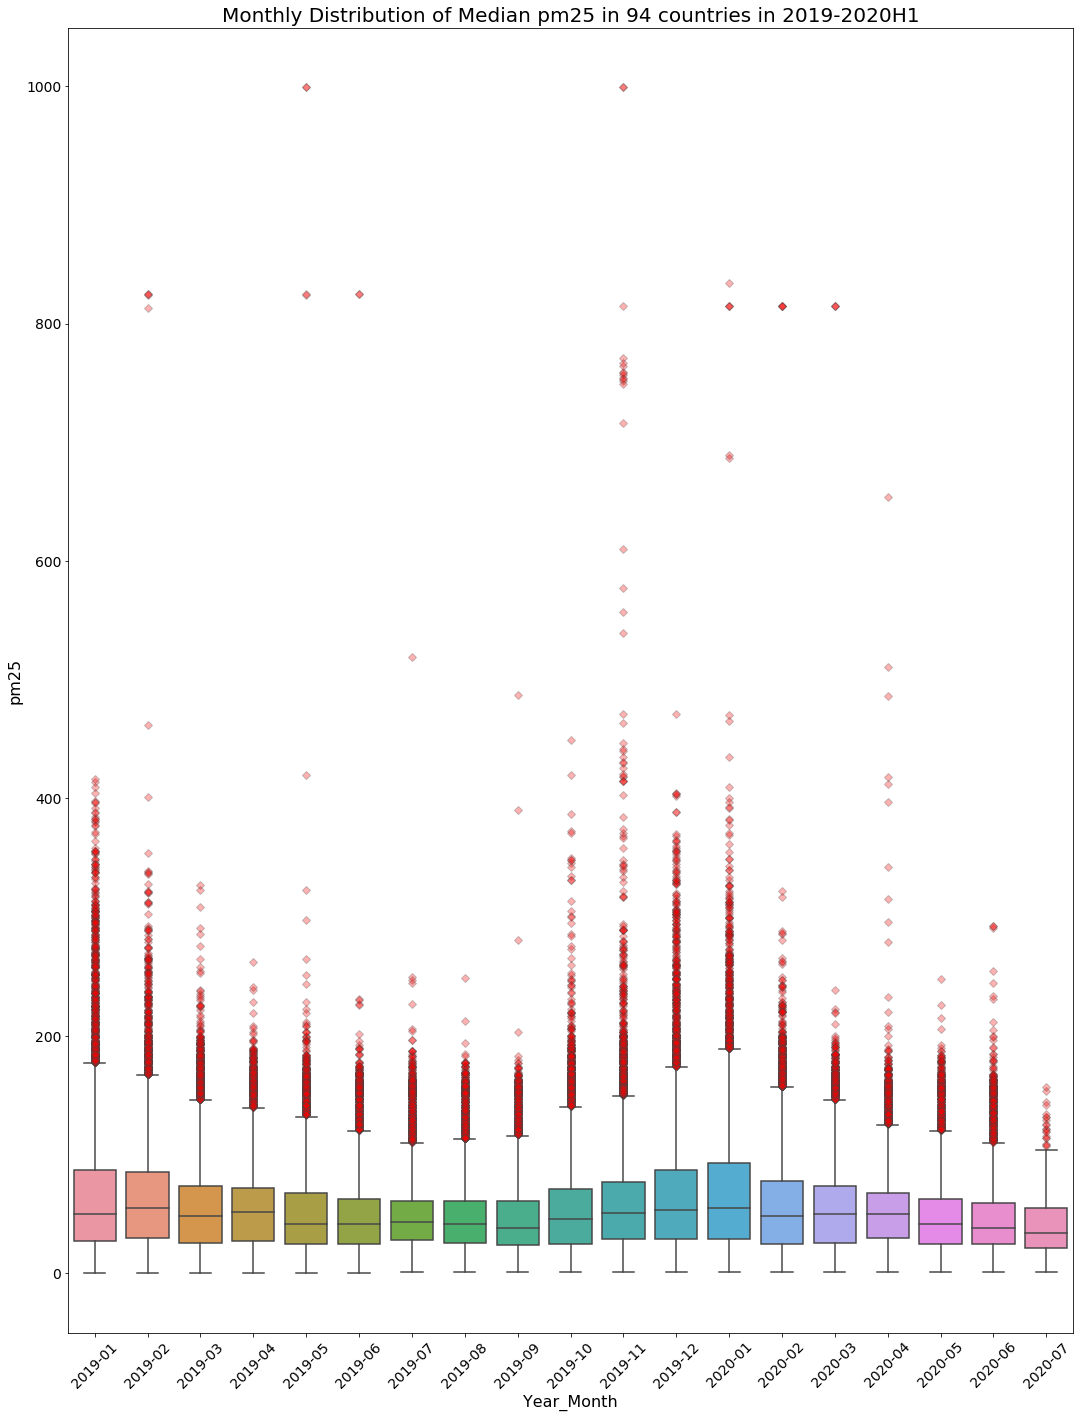

In [29]:
specie_boxplot("pm25")

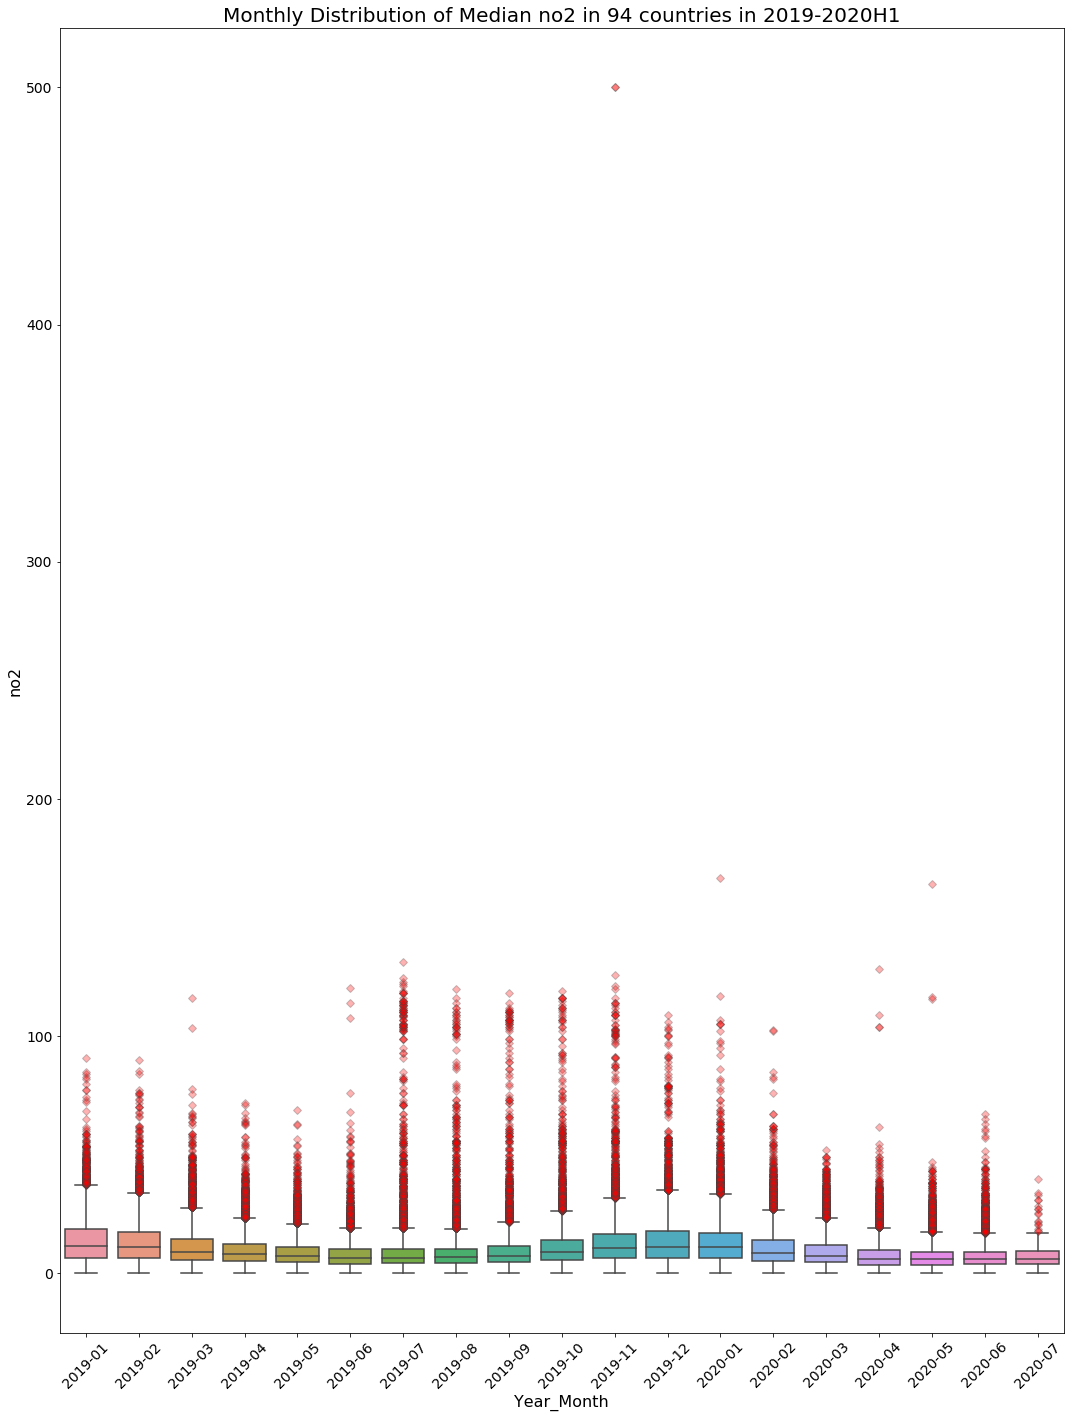

In [30]:
specie_boxplot("no2")

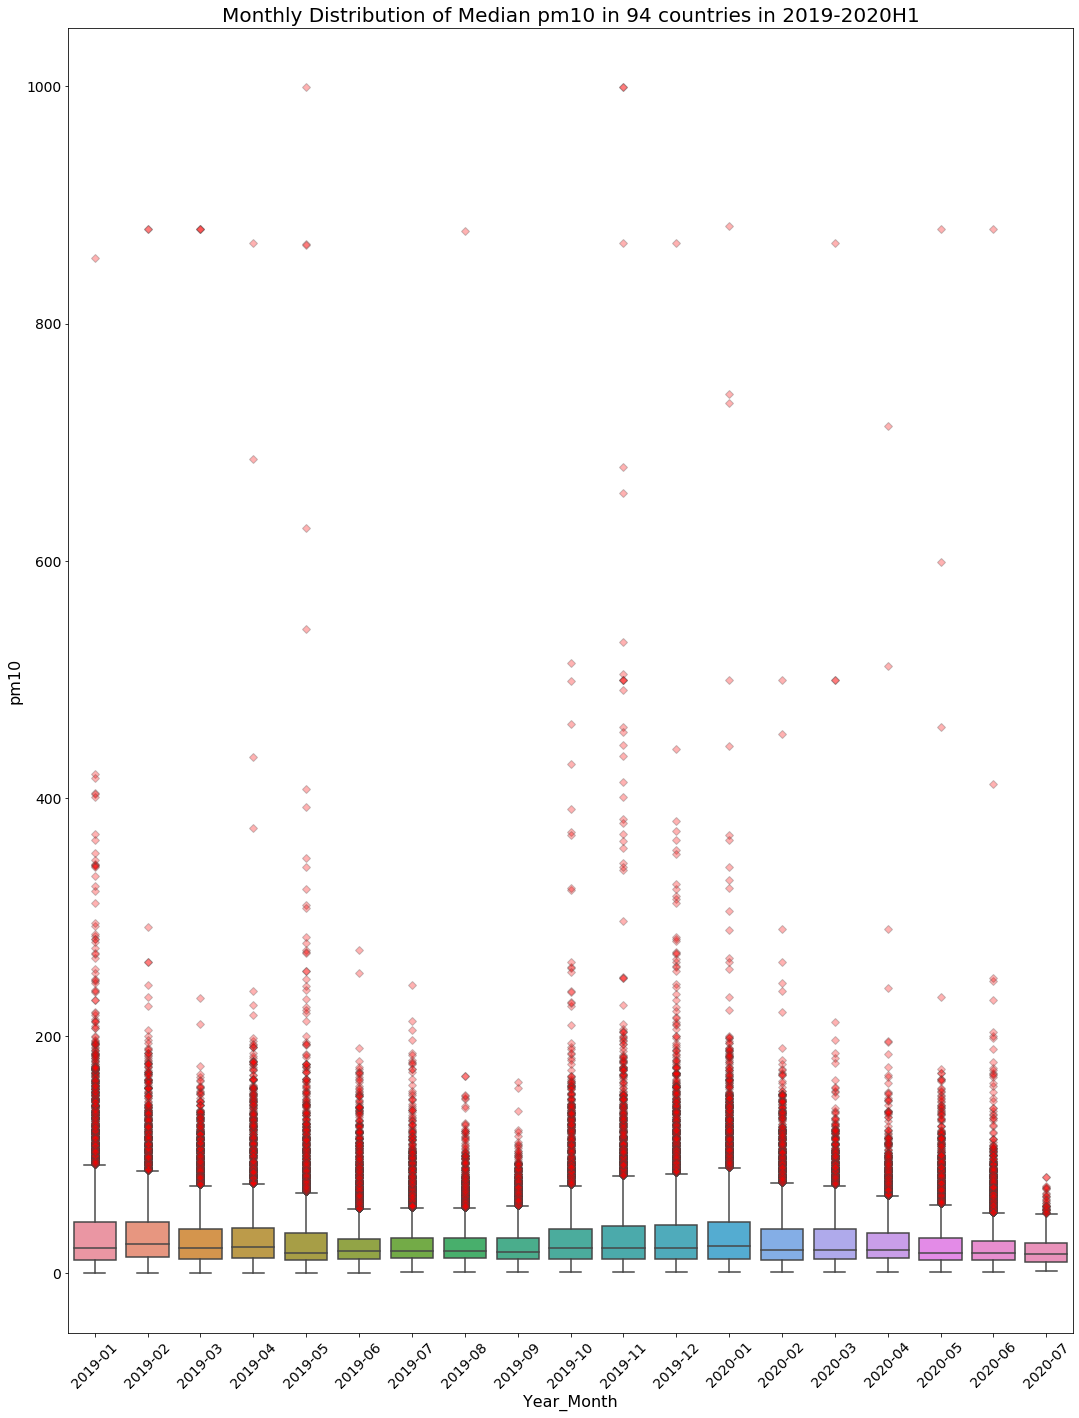

In [31]:
specie_boxplot("pm10")

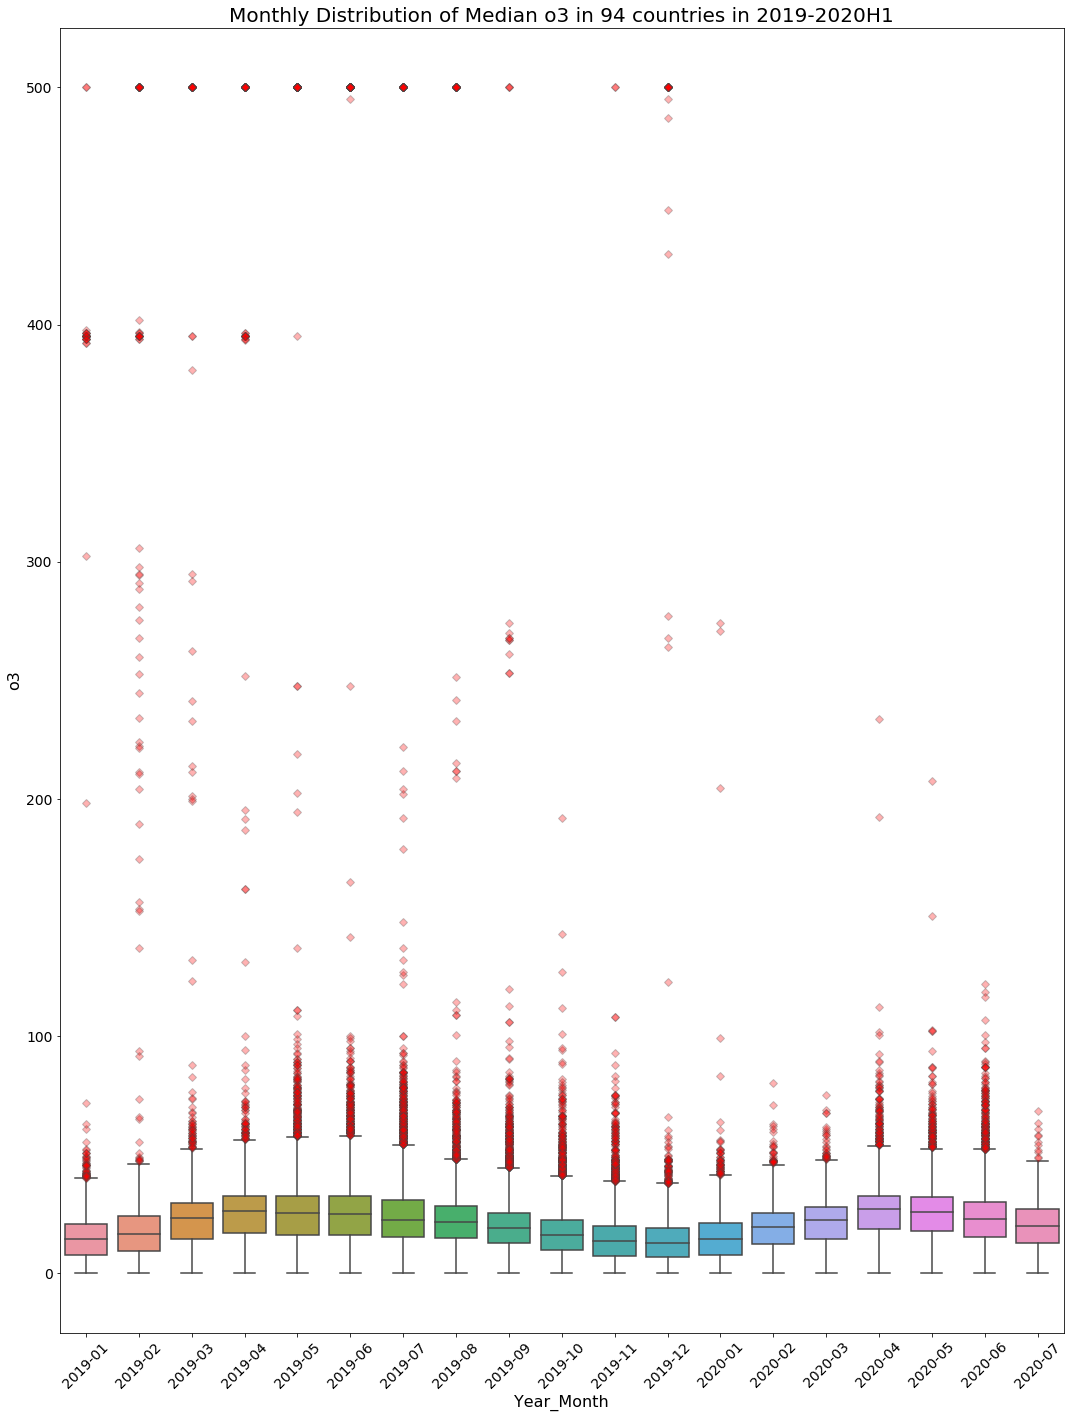

In [32]:
specie_boxplot("o3")

> **One interesting thing about the o3 chart is that it seems to even go up in the 2020H1. The reason could be that the ground-level ozone is created by a chemical reaction in the presence of sunlight. Hence the ozone levels tend to be higher in the summertime - https://learn.kaiterra.com/en/air-academy/5-major-outdoor-air-pollutants**

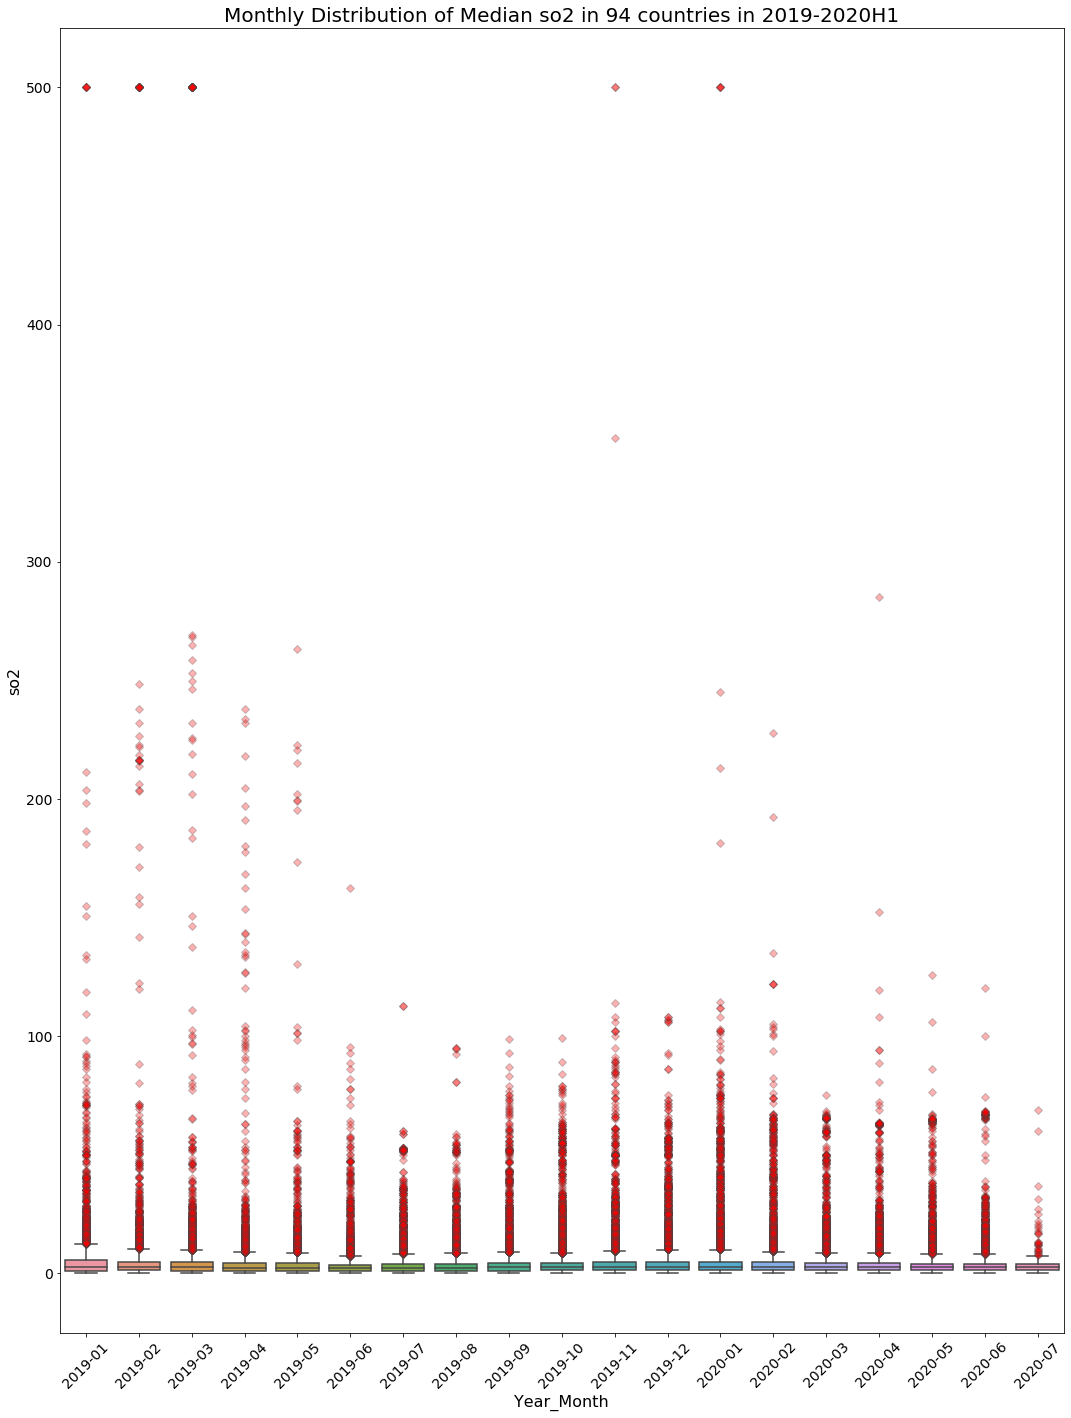

In [33]:
specie_boxplot("so2")

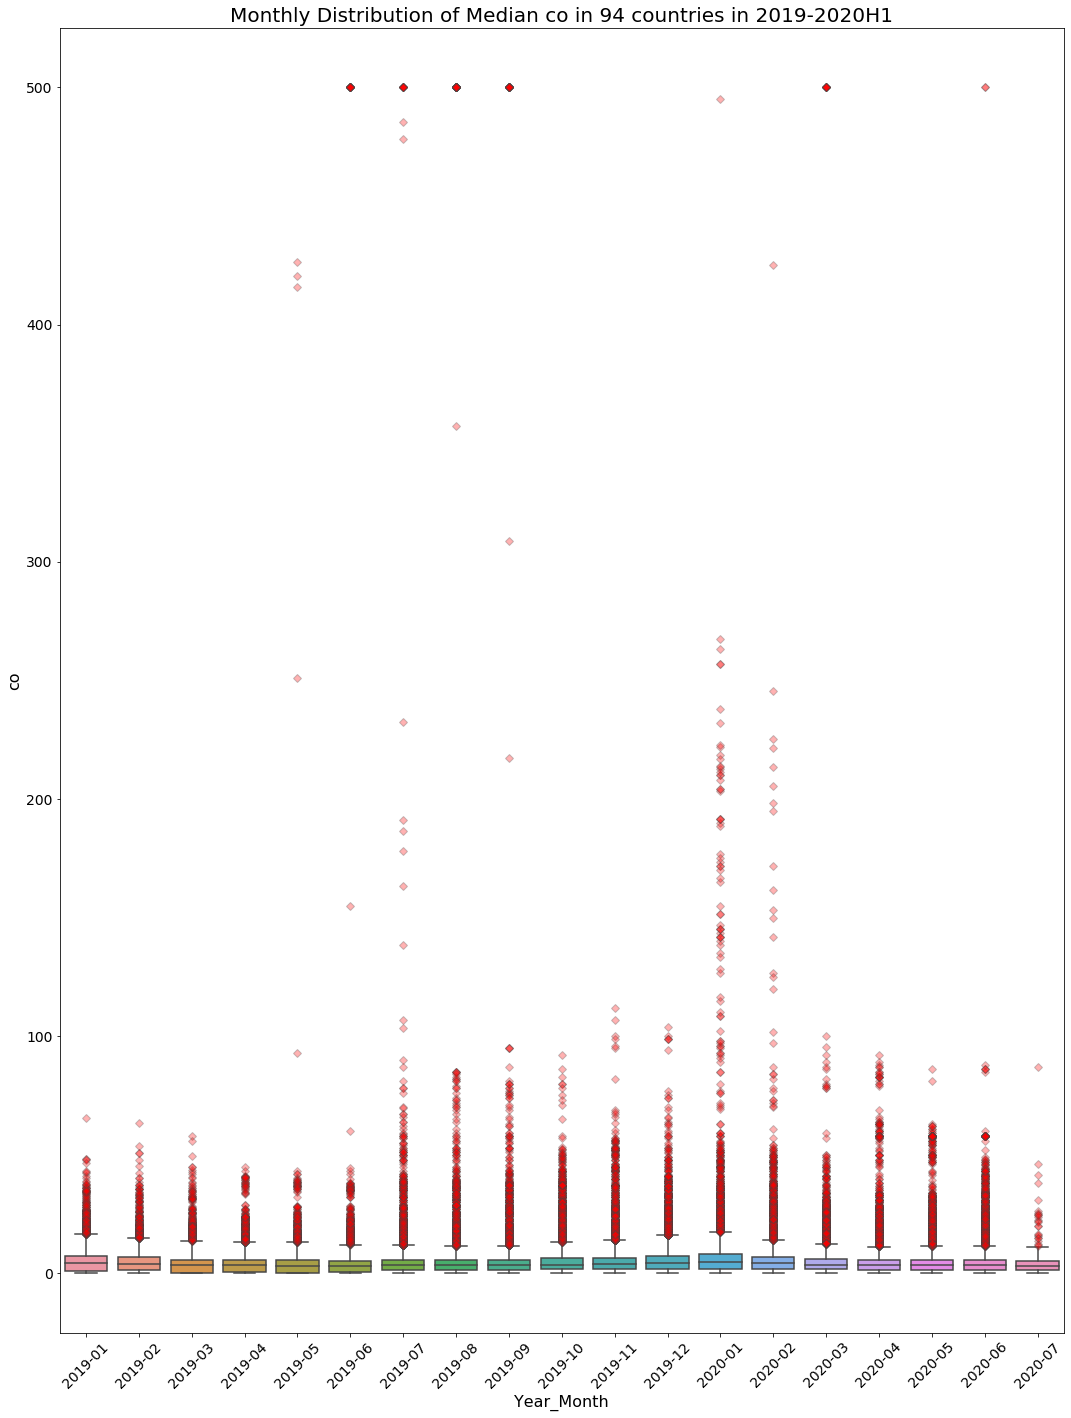

In [34]:
specie_boxplot("co")

> **As we can see from the above boxplots, there are quite a few extreme values in the the median measurements of the 6 air pollutants (pm2.5, no2, pm10, o3, so2 and co). However, due to our time and especially knowledge limitation regarding the air pollutants, we'll not remove any extreme values. We'd like to draw attention from anyone with the domain knowledge to this issue. Any should-be-removed outliers would have some impact on our following analysis.**

> **From the overview of the above boxplots, there seems to be no clear downward trend in the 6 air pollutants throughout 2019 to the first half of 2020. There are some decreasing trends in the monthly distribution of median pm2.5, no2 and pm10 values from around the end of 2019 to the first six months of 2020. However, there are no clear downward trends comparing the 2019H1 with the 2020H1.**

> **We'll zoom in two countries Australia and India to visualise their air quality change from 2019 to 2020H1. We chose Australia because it is so close to our hearts. In Australia, we chose Melbourne, Sydney and Perth to visualise how some of the six air pollutants have changed from 2019 to now. Melbourne and Sydney are the two most populous cities in Australia, and Perth is home to one of our team members. Out of the three cities, we'll visualise the change of all of the 6 air pollutants in Melbourne to get a deeper understanding.**

> **For our choice of India, we'd like to compare Australia with another country with vastly different environmental context. India is one of the most polluted countries in the world (https://worldpopulationreview.com/country-rankings/most-polluted-countries). For India, we chose to visualise three of its most populous cities: Mumbai, Delhi, Hyderabad**

> **Regarding choosing which air pollutant to plot, though we aim to visualise all of the 6 air pollutants (pm2.5, no2, pm10, o3, so2 and co), in some cases we will cover only some of them. The goal in this air data exploration is to have some tastes of how some of the air pollutants have changed in some cities in Australia and India.**

### Visualise air quality change in Australia (Melbourne, Sydney and Perth) in 2019-2020H1

* **Let's explore how the air quality has changed in Melbourne, Victoria.**

In [35]:
mel_air_df = clean_airdf.loc[(clean_airdf["Country"] == "AU") & (
    clean_airdf["City"] == "Melbourne")].sort_values("Date").set_index("Date")
mel_air_df.head()

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2019-01-01,AU,Melbourne,no2,117,1.0,12.1,2.8,81.70
2019-01-01,AU,Melbourne,co,18,1.2,2.3,1.2,3.20
2019-01-01,AU,Melbourne,o3,126,0.8,24.8,12.8,556.43
2019-01-01,AU,Melbourne,pm25,161,1.0,53.0,27.0,1398.93
2019-01-01,AU,Melbourne,pm10,124,2.0,49.0,14.0,566.48


In [36]:
mel_air_df["Specie"].value_counts()

o3      561
pm10    561
pm25    560
no2     558
co      541
so2     485
Name: Specie, dtype: int64

In [37]:
specie_list

['pm25', 'co', 'so2', 'no2', 'pm10', 'o3']

> "Unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series." - https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [38]:
def mel_air_specie(specie):
    specie_mel_air = mel_air_df[mel_air_df["Specie"] == specie]
    rolling_median_specie_mel_air = specie_mel_air["median"].rolling(30, center=True).mean()
    rolling_median_specie_mel_air.plot(figsize=(12, 5))
    
    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.title(f"30-day Moving Average of Median {specie} values in Melbourne in 2019-2020H1", fontsize=14)
    plt.savefig(f"images/melbourne_{specie}.png")

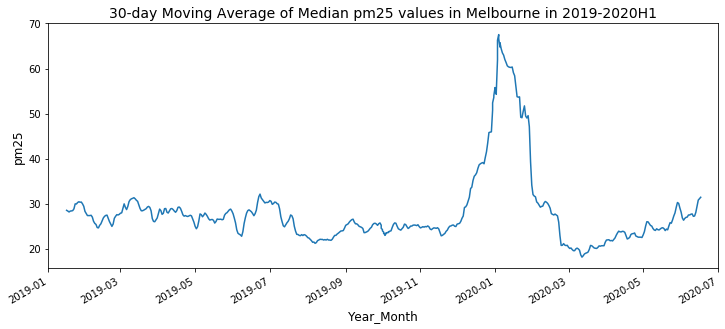

In [39]:
mel_air_specie("pm25")

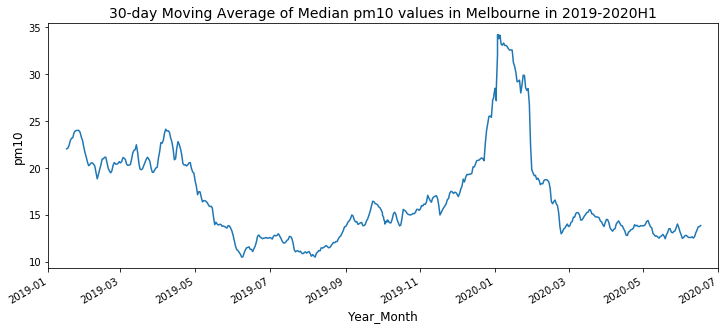

In [40]:
mel_air_specie("pm10")

> The particulate matters spiked significantly in January 2020, which would be explained by a series of massive bushfires raging Victoria in Jan 2020. The air pollutants pm2.5 and pm10 then dropped massively in the second quarter of 2020. This could be the short-term impacts of COVID-19 lockdown rules. The pm2.5 has been gradually increasing to the similar year-on-year level by the end of June 2020, though. The success of Melbourne in controlling the Covid-19 first wave, with gradually lifted social distancing rules towards the end of 2020Q2 could explain this observation.

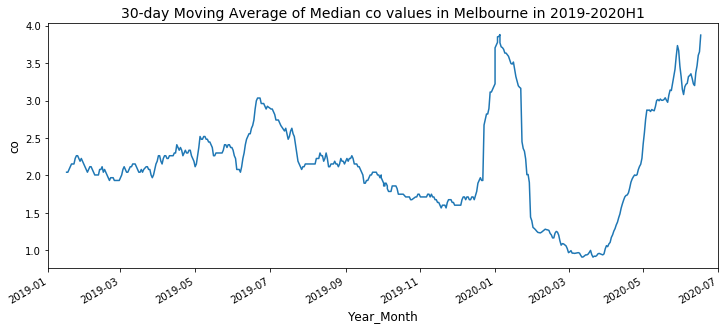

In [41]:
mel_air_specie("co")

> The CO level in Melbourne decreased substantially from January to April 2020, but then increased considerably from April to the end of 2020H1???? 

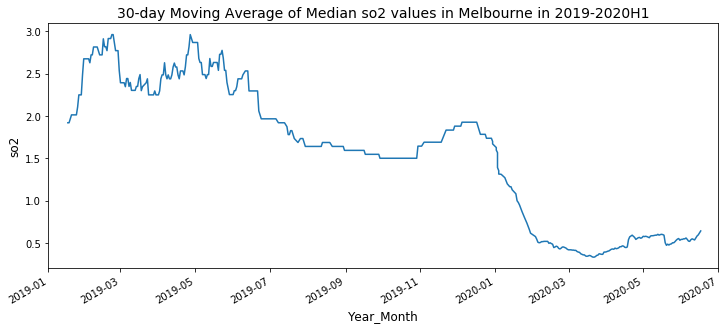

In [42]:
mel_air_specie("so2")

> The SO2 level in Melbourne dropped drastically from January through to the second quarter of 2020. Notably, this is a continuing downward trend from early 2019???

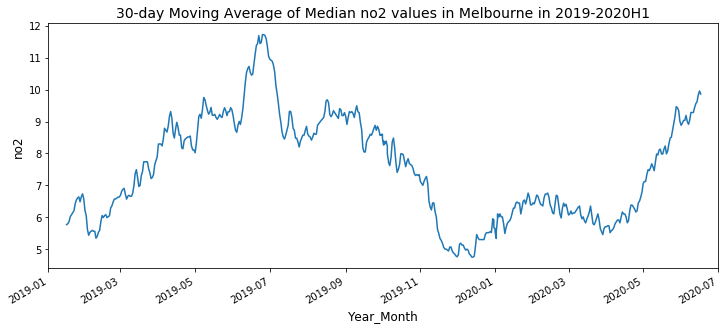

In [43]:
mel_air_specie("no2")

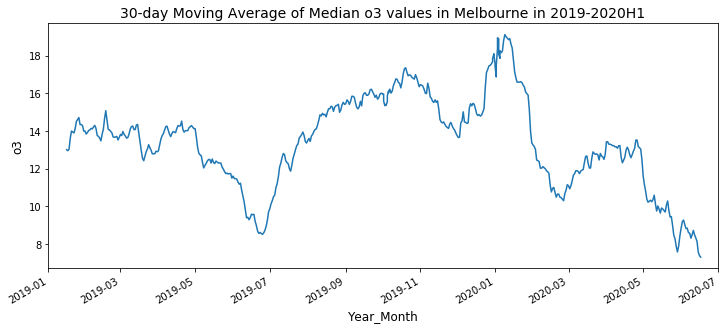

In [44]:
mel_air_specie("o3")

> There are no clear downward trends in the second half of 2020 in the level of NO2 and O3 during the period of COVID-19 first wave???

* **Let's explore how the air has changed in Melbourne, Sydney and Perth.**

In [45]:
def specie_cities(df, city_list, specie):
    
    specie_cities_df = df[(df["City"].isin(city_list)) & (df["Specie"] == specie)].sort_values("Date").copy()
    specie_cities_transposed_df = specie_cities_df.pivot_table(index="Date", columns="City", values="median")
    rolling_specie_cities = specie_cities_transposed_df[city_list].rolling(7, center=True).mean()
    
    plt.style.use('seaborn-bright')
    rolling_specie_cities.plot(figsize=(12, 5))
    
    plt.xlabel("Year_Month", fontsize=12)
    plt.xlim(starting_date, end_date)
    plt.ylabel(specie, fontsize=12)
    plt.title(f"7 day Moving Average of median {specie} in {city_list} in 2019-2020H1", fontsize=14)
    plt.savefig(f"images/{city_list}_{specie}.png")

In [46]:
au_air_df = clean_airdf.loc[clean_airdf["Country"]=="AU"]
au_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
171319,2020-02-04,AU,Sydney,co,56,1.2,4.5,3.4,10.12
171320,2020-03-29,AU,Sydney,co,9,1.2,3.4,2.3,9.07
171321,2020-06-26,AU,Sydney,co,45,1.2,6.7,2.3,17.91
171322,2020-05-22,AU,Sydney,co,14,1.2,2.3,1.2,2.19
171323,2020-06-04,AU,Sydney,co,33,1.2,5.6,2.3,16.16


In [47]:
au_cities_list = ["Sydney", "Melbourne", "Perth"]

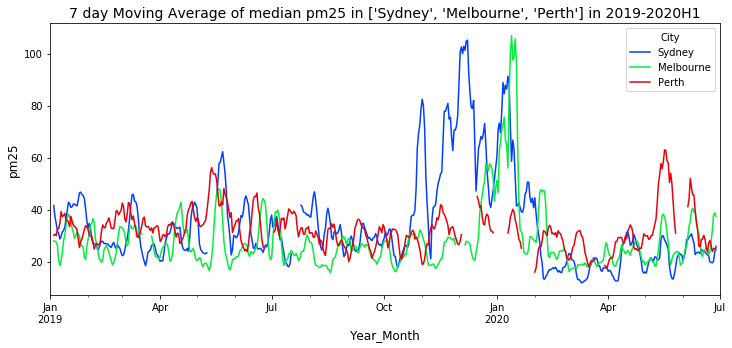

In [48]:
specie_cities(df=au_air_df, city_list=au_cities_list, specie="pm25")

> Some narratives here???

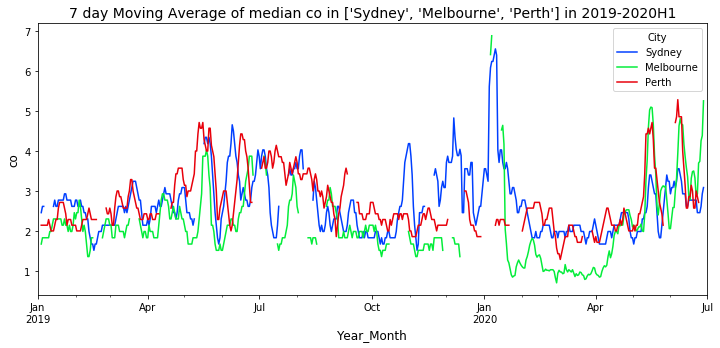

In [49]:
specie_cities(df=au_air_df, city_list=au_cities_list, specie="co")

> Some narratives here???

###  Visualise air quality change in India (Mumbai, Delhi, Hyderabad) in 2019-2020H1

In [50]:
in_air_df = clean_airdf.loc[clean_airdf["Country"]=="IN"]
in_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
422490,2020-02-24,IN,Thrissur,co,24,2.1,11.2,5.3,58.36
422491,2020-04-07,IN,Thrissur,co,72,2.3,13.6,8.1,131.11
422492,2020-04-24,IN,Thrissur,co,67,1.4,12.2,9.2,126.02
422493,2020-06-05,IN,Thrissur,co,72,0.7,26.8,14.1,532.05
422494,2020-06-13,IN,Thrissur,co,72,0.3,30.3,15.0,671.30


In [51]:
in_air_df["City"].value_counts()

Jaipur                3366
Delhi                 3366
Hyderabad             3366
Mumbai                3366
Bengaluru             3366
Kolkata               3366
Bhopal                3363
Ghāziābād             3330
Thiruvananthapuram    3289
Hāpur                 3288
Chandigarh            3201
Gandhinagar           3200
Nashik                3197
Visakhapatnam         3157
Muzaffarnagar         3105
Chennai               2985
Patna                 2958
Lucknow               2805
Shillong              2375
Thrissur              2243
Nagpur                1270
Mysore                1150
New Delhi              520
Name: City, dtype: int64

In [52]:
in_air_df["Specie"].value_counts()

pm25    11626
so2     11162
co      11141
o3      11132
no2     11092
pm10     9479
Name: Specie, dtype: int64

In [53]:
in_cities_list = ["Mumbai", "Delhi", "Hyderabad"]

* **Let's explore how air quality change via the movement in the air pollutants with the most available data points (pm2.5, so2, co, o3, no2, pm10) in three of the most populous cities in India: Mumbai, Delhi, Hyderabad**

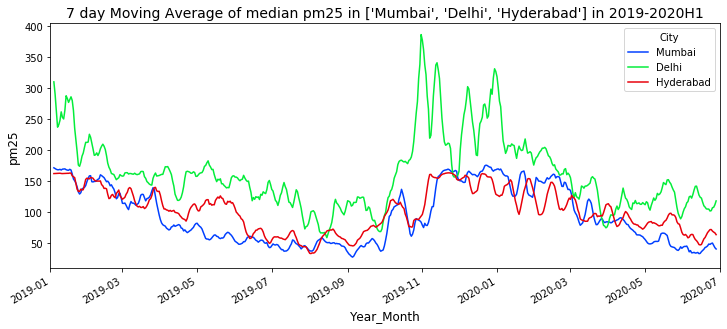

In [54]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="pm25")

> Some narratives here?

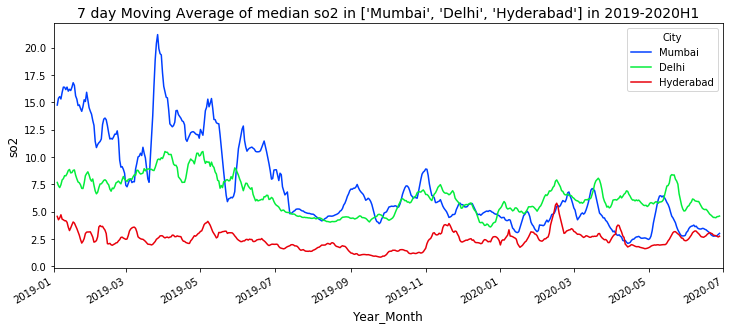

In [55]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="so2")

> Some narratives here???

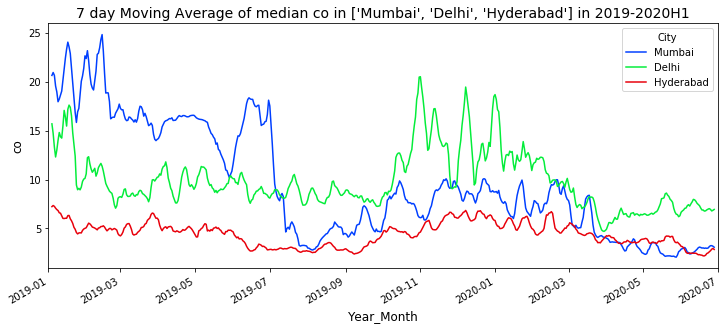

In [56]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="co")

> Some narratives here???

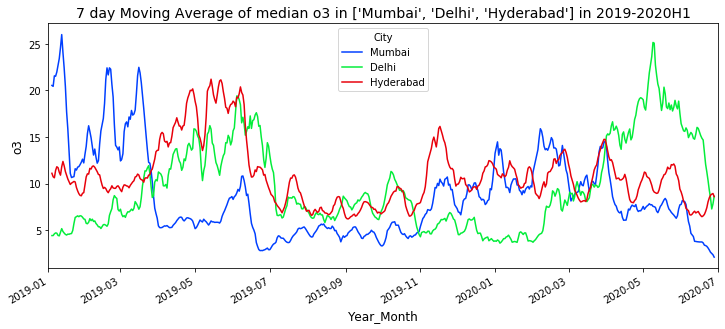

In [57]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="o3")

> Some narratives here???

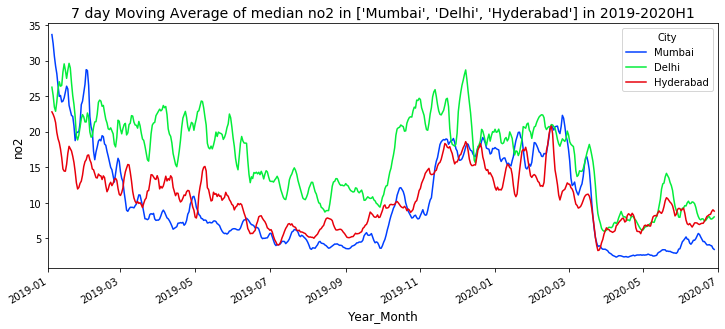

In [58]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="no2")

> Some narratives here???

## COVID-19 World Data Exploration and Clean Up

The Covid-19 world data is sourced from here https://covid19api.com/

In [59]:
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

[{'Country': 'Denmark', 'ISO2': 'DK', 'Slug': 'denmark'},
 {'Country': 'France', 'ISO2': 'FR', 'Slug': 'france'},
 {'Country': 'Guatemala', 'ISO2': 'GT', 'Slug': 'guatemala'},
 {'Country': 'Belarus', 'ISO2': 'BY', 'Slug': 'belarus'},
 {'Country': 'Bhutan', 'ISO2': 'BT', 'Slug': 'bhutan'},
 {'Country': 'Congo (Kinshasa)', 'ISO2': 'CD', 'Slug': 'congo-kinshasa'},
 {'Country': 'Lebanon', 'ISO2': 'LB', 'Slug': 'lebanon'},
 {'Country': 'Papua New Guinea', 'ISO2': 'PG', 'Slug': 'papua-new-guinea'},
 {'Country': 'Sierra Leone', 'ISO2': 'SL', 'Slug': 'sierra-leone'},
 {'Country': 'Anguilla', 'ISO2': 'AI', 'Slug': 'anguilla'},
 {'Country': 'Czech Republic', 'ISO2': 'CZ', 'Slug': 'czech-republic'},
 {'Country': 'Ecuador', 'ISO2': 'EC', 'Slug': 'ecuador'},
 {'Country': 'Montenegro', 'ISO2': 'ME', 'Slug': 'montenegro'},
 {'Country': 'Somalia', 'ISO2': 'SO', 'Slug': 'somalia'},
 {'Country': 'Syrian Arab Republic (Syria)', 'ISO2': 'SY', 'Slug': 'syria'},
 {'Country': 'Viet Nam', 'ISO2': 'VN', 'Slug'

In [60]:
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

,Country,Slug,ISO2
0,Denmark,denmark,DK
1,France,france,FR
2,Guatemala,guatemala,GT
3,Belarus,belarus,BY
4,Bhutan,bhutan,BT
...,...,...,...
243,Serbia,serbia,RS
244,Suriname,suriname,SR
245,Algeria,algeria,DZ
246,Bahamas,bahamas,BS


In [61]:
final_air_df = pd.merge(clean_airdf, country_covid_df, how="inner",
                        left_on="Country", right_on="ISO2", suffixes=("_code", "_name"))
final_air_df.head(10)

,Date,Country_code,City,Specie,count,min,max,median,variance,Country_name,Slug,ISO2
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40,"Iran, Islamic Republic of",iran,IR
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00,"Iran, Islamic Republic of",iran,IR
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56,"Iran, Islamic Republic of",iran,IR
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80,"Iran, Islamic Republic of",iran,IR
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67,"Iran, Islamic Republic of",iran,IR
5,2020-05-19,IR,Isfahan,pm25,168,31.0,172.0,89.0,6310.77,"Iran, Islamic Republic of",iran,IR
6,2020-05-30,IR,Isfahan,pm25,115,36.0,164.0,78.0,5630.48,"Iran, Islamic Republic of",iran,IR
7,2020-01-22,IR,Isfahan,pm25,145,59.0,141.0,91.0,4123.42,"Iran, Islamic Republic of",iran,IR
8,2020-01-23,IR,Isfahan,pm25,134,42.0,109.0,63.0,1529.14,"Iran, Islamic Republic of",iran,IR
9,2020-03-06,IR,Isfahan,pm25,94,58.0,195.0,111.0,9950.79,"Iran, Islamic Republic of",iran,IR


In [62]:
del final_air_df["ISO2"]
final_air_df.head()

,Date,Country_code,City,Specie,count,min,max,median,variance,Country_name,Slug
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40,"Iran, Islamic Republic of",iran
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00,"Iran, Islamic Republic of",iran
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56,"Iran, Islamic Republic of",iran
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80,"Iran, Islamic Republic of",iran
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67,"Iran, Islamic Republic of",iran


In [63]:
final_air_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1475237 entries, 0 to 1475236
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1475237 non-null  datetime64[ns]
 1   Country_code  1475237 non-null  object        
 2   City          1475237 non-null  object        
 3   Specie        1475237 non-null  object        
 4   count         1475237 non-null  int64         
 5   min           1475237 non-null  float64       
 6   max           1475237 non-null  float64       
 7   median        1475237 non-null  float64       
 8   variance      1475237 non-null  float64       
 9   Country_name  1475237 non-null  object        
 10  Slug          1475237 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 135.1+ MB


In [64]:
# Explore one covid API - By Country Total All Status
covid_url_example = "https://api.covid19api.com/total/country/australia"
covid_data_example = requests.get(covid_url_example).json()
pprint(covid_data_example)

[{'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-22T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-23T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-24T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 0,
  'City': '',
  'CityCode': '',
  'Confirmed': 0,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-01-25T00:00:00Z',
  'Deaths': 0,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 0},
 {'Active': 4,
  'City': '',
  'CityCode': '',
  'Confirmed': 4,
  'Country': 'Australia',
  'Co

  'Date': '2020-04-13T00:00:00Z',
  'Deaths': 61,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 1806},
 {'Active': 4167,
  'City': '',
  'CityCode': '',
  'Confirmed': 6415,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-14T00:00:00Z',
  'Deaths': 62,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 2186},
 {'Active': 4191,
  'City': '',
  'CityCode': '',
  'Confirmed': 6440,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-15T00:00:00Z',
  'Deaths': 63,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 2186},
 {'Active': 4044,
  'City': '',
  'CityCode': '',
  'Confirmed': 6462,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-16T00:00:00Z',
  'Deaths': 63,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 2355},
 {'Active': 2648,
  'City': '',
  'CityCode': '',
  'Confirmed': 6522,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-04-17T00:00:00Z',
  'Deaths': 66,
  'Lat

  'Confirmed': 7347,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-15T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6856},
 {'Active': 407,
  'City': '',
  'CityCode': '',
  'Confirmed': 7370,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-16T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6861},
 {'Active': 412,
  'City': '',
  'CityCode': '',
  'Confirmed': 7391,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-17T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6877},
 {'Active': 429,
  'City': '',
  'CityCode': '',
  'Confirmed': 7409,
  'Country': 'Australia',
  'CountryCode': '',
  'Date': '2020-06-18T00:00:00Z',
  'Deaths': 102,
  'Lat': '0',
  'Lon': '0',
  'Province': '',
  'Recovered': 6878},
 {'Active': 428,
  'City': '',
  'CityCode': '',
  'Confirmed': 7411,
  'Country': 'Australia',
  'Countr

The above api example covers the covid-19 data up-to-date. It also shows the number of confirmed, active, recovered, and death cases for each chosen country over the course of the current pandemic. Hence, we'll use this api to loop through the countries in our air quality data.

In [65]:
slug_list = final_air_df["Slug"].unique().tolist()
len(slug_list)

93

In [66]:
base_covid_url = "https://api.covid19api.com/total/country/"
    
country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:
    
    try:
        response = requests.get(base_covid_url + slug).json()
    
        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

Beginning Data Retrieval
-----------------------------------
Processing Record 1 of Set 1 | iran
Processing Record 2 of Set 1 | tajikistan
Processing Record 3 of Set 1 | brazil
Processing Record 4 of Set 1 | china
Processing Record 5 of Set 1 | denmark
Processing Record 6 of Set 1 | spain
Processing Record 7 of Set 1 | mali
Processing Record 8 of Set 1 | slovakia
Processing Record 9 of Set 1 | kosovo
Processing Record 10 of Set 1 | chile
Processing Record 11 of Set 1 | germany
Processing Record 12 of Set 1 | kuwait
Processing Record 13 of Set 1 | myanmar
Processing Record 14 of Set 1 | philippines
Processing Record 15 of Set 1 | pakistan
Processing Record 16 of Set 1 | poland
Processing Record 17 of Set 1 | russia
Processing Record 18 of Set 1 | sweden
Processing Record 19 of Set 1 | singapore
Processing Record 20 of Set 1 | united-arab-emirates
Processing Record 21 of Set 1 | bosnia-and-herzegovina
Processing Record 22 of Set 1 | czech-republic
Processing Record 23 of Set 1 | indonesi

In [67]:
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

,Country,Date,Active cases,Confirmed cases,Recovered cases,Deaths
0,"Iran, Islamic Republic of",2020-01-22T00:00:00Z,0,0,0,0
1,"Iran, Islamic Republic of",2020-01-23T00:00:00Z,0,0,0,0
2,"Iran, Islamic Republic of",2020-01-24T00:00:00Z,0,0,0,0
3,"Iran, Islamic Republic of",2020-01-25T00:00:00Z,0,0,0,0
4,"Iran, Islamic Republic of",2020-01-26T00:00:00Z,0,0,0,0


In [68]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14960 entries, 0 to 14959
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          14960 non-null  object
 1   Date             14960 non-null  object
 2   Active cases     14960 non-null  int64 
 3   Confirmed cases  14960 non-null  int64 
 4   Recovered cases  14960 non-null  int64 
 5   Deaths           14960 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 701.4+ KB


In [69]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [70]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

Timestamp('2020-01-22 00:00:00')

In [71]:
# Find the latrest date the covid dataset covers:
covid_df["Date"].max()

Timestamp('2020-07-09 00:00:00')

In [72]:
# Set cutoff date to the latest date on the air quality data
world_covid_df = covid_df[covid_df["Date"] <= end_date]

In [73]:
world_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14256 entries, 0 to 14951
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Country          14256 non-null  object        
 1   Date             14256 non-null  datetime64[ns]
 2   Active cases     14256 non-null  int64         
 3   Confirmed cases  14256 non-null  int64         
 4   Recovered cases  14256 non-null  int64         
 5   Deaths           14256 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 779.6+ KB


In [74]:
world_covid_df["Country"].nunique()

88

In [75]:
air_covid_common_country_list = world_covid_df["Country"].unique().tolist()
air_covid_common_country_list

['Iran, Islamic Republic of',
 'Tajikistan',
 'Brazil',
 'China',
 'Denmark',
 'Spain',
 'Mali',
 'Slovakia',
 'Republic of Kosovo',
 'Chile',
 'Germany',
 'Kuwait',
 'Myanmar',
 'Philippines',
 'Pakistan',
 'Poland',
 'Russian Federation',
 'Sweden',
 'Singapore',
 'United Arab Emirates',
 'Bosnia and Herzegovina',
 'Czech Republic',
 'Indonesia',
 'Iceland',
 'Romania',
 'Argentina',
 'Australia',
 'Ecuador',
 'Ghana',
 'Peru',
 'Ukraine',
 'Estonia',
 'France',
 'Japan',
 'Mongolia',
 'Finland',
 'Ireland',
 'Israel',
 'Kazakhstan',
 'Lao PDR',
 'Uzbekistan',
 'Bangladesh',
 'Belgium',
 'Greece',
 'Korea (South)',
 'Sri Lanka',
 'Macedonia, Republic of',
 'Mexico',
 'Turkey',
 'Afghanistan',
 'Austria',
 'Guatemala',
 'Bolivia',
 'Costa Rica',
 'Jordan',
 'Saudi Arabia',
 'El Salvador',
 'Canada',
 'Italy',
 'Norway',
 'South Africa',
 'Bahrain',
 'Lithuania',
 'Thailand',
 'Bulgaria',
 'Switzerland',
 'Hungary',
 'Netherlands',
 'New Zealand',
 'Uganda',
 'Viet Nam',
 'Ethiopia',
 

In [76]:
final_clean_air_df = final_air_df[final_air_df["Country_name"].isin(air_covid_common_country_list)]
final_clean_air_df.head()

,Date,Country_code,City,Specie,count,min,max,median,variance,Country_name,Slug
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40,"Iran, Islamic Republic of",iran
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00,"Iran, Islamic Republic of",iran
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56,"Iran, Islamic Republic of",iran
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80,"Iran, Islamic Republic of",iran
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67,"Iran, Islamic Republic of",iran


In [77]:
final_clean_air_df["Country_name"].nunique()

88

In [78]:
del final_clean_air_df["Slug"]
final_clean_air_df.head()

,Date,Country_code,City,Specie,count,min,max,median,variance,Country_name
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40,"Iran, Islamic Republic of"
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00,"Iran, Islamic Republic of"
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56,"Iran, Islamic Republic of"
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80,"Iran, Islamic Republic of"
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67,"Iran, Islamic Republic of"


In [79]:
final_clean_air_df.to_csv("output_csv/clean_world_air.csv", index=False)

In [80]:
world_covid_df.tail()

,Country,Date,Active cases,Confirmed cases,Recovered cases,Deaths
14947,United States of America,2020-06-27,1704831,2510259,679308,126120
14948,United States of America,2020-06-28,1737770,2549294,685164,126360
14949,United States of America,2020-06-29,1758754,2590668,705203,126711
14950,United States of America,2020-06-30,1788351,2636414,720631,127432
14951,United States of America,2020-07-01,1829489,2687588,729994,128105


In [81]:
world_active_covid = world_covid_df[["Date", "Country", "Active cases"]].sort_values("Date").copy()
world_active_covid.head()

,Date,Country,Active cases
0,2020-01-22,"Iran, Islamic Republic of",0
12580,2020-01-22,Iraq,0
2040,2020-01-22,Myanmar,0
12410,2020-01-22,Guinea,0
2210,2020-01-22,Philippines,0


In [82]:
au_covid = world_active_covid[world_active_covid["Country"]=="Australia"].copy()
au_covid.head()

,Date,Country,Active cases
4420,2020-01-22,Australia,0
4421,2020-01-23,Australia,0
4422,2020-01-24,Australia,0
4423,2020-01-25,Australia,0
4424,2020-01-26,Australia,4


In [83]:
au_covid.to_csv("output_csv/active_au_covid.csv", index=False)

In [84]:
india_covid = world_active_covid[world_active_covid["Country"]=="India"].copy()
india_covid.head()

,Date,Country,Active cases
13940,2020-01-22,India,0
13941,2020-01-23,India,0
13942,2020-01-24,India,0
13943,2020-01-25,India,0
13944,2020-01-26,India,0


In [85]:
india_covid.to_csv("output_csv/active_india_covid.csv", index=False)

In [86]:
world_active_covid_transposed = world_active_covid.pivot_table(index="Date", columns="Country", values="Active cases")
world_active_covid_transposed.head()

Country,Afghanistan,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belgium,Bolivia,Bosnia and Herzegovina,...,Tajikistan,Thailand,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States of America,Uzbekistan,Viet Nam
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,1,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,1,0,2
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,2,0,2
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,0,0,0,2,0,2
2020-01-26,0,0,0,4,0,0,0,0,0,0,...,0,6,0,0,0,0,0,5,0,2


In [87]:
world_active_covid_transposed["Total active cases"] = world_active_covid_transposed.sum(axis=1)
world_active_covid_transposed.head()

Country,Afghanistan,Algeria,Argentina,Australia,Austria,Bahrain,Bangladesh,Belgium,Bolivia,Bosnia and Herzegovina,...,Thailand,Turkey,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States of America,Uzbekistan,Viet Nam,Total active cases
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,510
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,1,0,2,606
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,2,0,2,879
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,2,0,2,1350
2020-01-26,0,0,0,4,0,0,0,0,0,0,...,6,0,0,0,0,0,5,0,2,2005


In [88]:
total_active_world_covid = world_active_covid_transposed["Total active cases"].to_frame().reset_index()
total_active_world_covid.head()

,Date,Total active cases
0,2020-01-22,510
1,2020-01-23,606
2,2020-01-24,879
3,2020-01-25,1350
4,2020-01-26,2005


In [89]:
total_active_world_covid.to_csv("output_csv/active_world_covid.csv", index=False)